In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sp
import time

Here, we create a $n\times m$ matrix $X$ and a $n\times p$ matrix $Y$, where
* $n$ is the number of samples;
* $m$ is the number of human genetic variants;
* $p$ is the number of pathogen genetic variants.

In [38]:
# Returns the means of the matrix for centralization
def getMean(mat):
    return np.tile(np.mean(mat, axis = 0),(mat.shape[0],1))

# This function calculates the variance in the original matrix
def getVariance(mat):
    totalVar = 0
    for i in range(mat.shape[1]):
        totalVar += np.var(mat[:,i])
    return totalVar*(mat.shape[0])/(mat.shape[0] - 1)

# Plot variance graph 
def plotVar(varXAry, varYAry, varXTotal, varYTotal):
    numFactor = len(varXAry)
    numFactorAry = np.arange(1, numFactor + 1)
    plt.plot(numFactorAry, np.cumsum(varXAry/varXTotal), color = 'c', label = 'varX')
    plt.plot(numFactorAry, np.cumsum(varYAry)/varYTotal, color = 'm', label = 'varY')
    plt.axhline(y = 1, color = 'g', linestyle = '--')
    plt.xlabel('number of factors')
    plt.ylabel('percent variance explained')
    plt.legend()
    plt.title('variance explained in $X$ and $Y$')
    plt.show()
    
# The SIMPLS algorithm
def SIMPLS(X, Y, numFactor):
    varXAry = []
    varYAry = []
    varSAry = []
    tAry = []
    
    numSample = X.shape[0]
    numHuman = X.shape[1]
    numPathogen = Y.shape[1]
    
    Y = Y - np.tile(np.mean(Y, axis = 0),(numSample,1)) # Centralize Y
    S = (X.T @ Y) # Calculate S
    for a in range(1, numFactor+1):
        varSAry.append(getVariance(S.T @ S))
        _, q = sp.eigh(S.T @ S, subset_by_index=[numPathogen-1, numPathogen-1]) # q is the dominant eigenvector
        r = S @ q
        t = X @ r
        t = t - np.mean(t)
        normt = np.sqrt(t.T @ t)
        t = t/normt
        r = r/np.sqrt(r.T @ r)
        p = X.T @ t
        q = Y.T @ t
        u = Y @ q
        v = p
        if a > 1:
            v = v - V @ (V.T @ p)
            u = u - T @ (T.T @ u)
        v = v/np.sqrt(v.T @ v)
        S = S - v @ (v.T @ S)
        R, T, P, Q, U, V = r, t, p, q, u, v
        tAry.append(t)
        varXAry.append(np.diag((P.T @ P)/(numSample - 1))[0])
        varYAry.append(np.diag((Q.T @ Q)/(numSample - 1))[0])
        # If the information is already extracted, stop the algorithm immediately
        if abs(np.sum(varYAry) - getVariance(Y)) < 1e-10:
            B = R @ Q.T
            h = np.diag(T @ T.T) + 1/numSample
            return B, tAry, varXAry, varYAry, varSAry
    B = R @ Q.T
    h = np.diag(T @ T.T) + 1/numSample
    return B, tAry, varXAry, varYAry, varSAry

In [3]:
class Human:
    def __init__(self, n_pop, n_var, ploidy = 2):
        self.n_pop = n_pop
        self.n_var = n_var
        self.ploidy = ploidy
        self.X = np.random.randint(low = 0, high = ploidy + 1, size =(n_pop, n_var)) # nxm matrix X

class Virus:
    def __init__(self, human, n_var, ploidy = 1):
        self.X = human.X
        self.n_pop = self.X.shape[0]
        self.n_var = n_var
        self.ploidy = ploidy
        self.Y = np.random.randint(low = 0, high = ploidy + 1, size =(self.n_pop, self.n_var)) # nxp matrix Y

In [29]:
def transfer(mat, model = 'additive'):
    if model == 'additive':
        return mat/2
    elif model == 'force':
        tmp = np.where(mat >= 0.5, 1, mat)
        return np.where(tmp < 0.5, 0, tmp)
    elif model == 'dominant':
        return np.where(mat == 2, 1, mat)
    else:
        tmp = np.where(mat == 2, 1, mat)
        return np.where(tmp == 1, 0, tmp)
    
def affect(mat, weight = np.array([1]), model = 'additive', encode = True):
    mat = transfer(mat, model)
    dosage = mat*weight
    if len(weight) != 1:
        dosage = np.sum(dosage, axis = 1)
    return transfer(dosage, model = 'force')

In [33]:
h = Human(4, 10)
v = Virus(h, 5)
# v.Y[:,2] = v.X[:, 5]

In [34]:
v.X

array([[2, 1, 0, 1, 2, 2, 2, 2, 2, 2],
       [0, 1, 1, 2, 1, 1, 0, 2, 1, 0],
       [2, 0, 0, 1, 2, 0, 0, 1, 1, 0],
       [2, 2, 2, 0, 1, 2, 0, 2, 1, 1]])

In [35]:
v.Y

array([[0, 0, 0, 0, 1],
       [0, 0, 1, 1, 0],
       [1, 1, 0, 0, 0],
       [0, 0, 1, 1, 0]])

In [71]:
B, t, varX1Ary, varY1Ary, varS1Ary = SIMPLS(v.X, v.Y, 10)

In [69]:
varX1Total = getVariance(v.X)
varY1Total = getVariance(v.Y)

In [75]:
(v.X - getMean(v.X)) @ B

array([[-0.10883007, -0.10883007,  0.10883007,  0.02824296,  0.08058711],
       [-0.38573524, -0.38573524,  0.38573524,  0.10010382,  0.28563142],
       [ 0.14697121,  0.14697121, -0.14697121, -0.03814113, -0.10883007],
       [ 0.34759411,  0.34759411, -0.34759411, -0.09020565, -0.25738846]])

In [59]:
varS1Ary

[108.78125, 27.768995481667712, 0.30017042271575833]

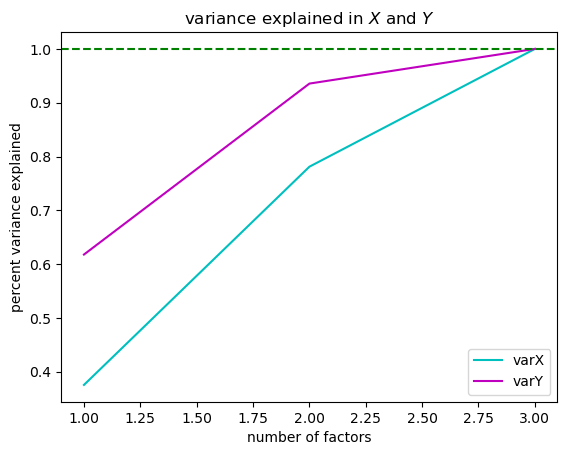

In [70]:
plotVar(varX1Ary, varY1Ary, varX1Total, varY1Total)

In [2]:
# Create two matrices: a nxp matrix X and a nxm matrix Y
numSample = 100
numHuman = 1000
numPathogen = 800
numFactor = 50 # Number of factors A

X1 = np.random.randint(low = 0, high = 3, size =(numSample, numHuman)) # nxp matrix X
Y1 = np.random.randint(low = 0, high = 3, size =(numSample, numPathogen)) # nxm matrix Y

In [202]:
varX1Total = getVariance(X1)
varY1Total = getVariance(Y1)

print('1st example:')
print("varX:", varX1Total)
print("varY:", varY1Total)

1st example:
varX: 665.8364646464637
varY: 532.5343434343433


In [4]:
Y2 = np.random.randint(low = 0, high = 3, size =(numSample, numPathogen)) # nxm matrix Y
X2 = np.hstack((Y2, Y2[:, :(numHuman - numPathogen)]))

In [207]:
varX2Total = getVariance(X2)
varY2Total = getVariance(Y2)

print('2nd example:')
print("varX:", varX2Total)
print("varY:", varY2Total)

2nd example:
varX: 667.617474747474
varY: 534.3596969696966


In [6]:
X3 = np.random.randint(low = 0, high = 3, size =(numSample, numHuman)) # nxm matrix Y
Y3 = X3[:, :numPathogen]

In [208]:
varX3Total = getVariance(X3)
varY3Total = getVariance(Y3)

print('3rd example:')
print("varX:", varX3Total)
print("varY:", varY3Total)

3rd example:
varX: 666.4890909090911
varY: 533.6479797979797


Here, the main SIMPLS algorithm is adapted from the original paper (p262 of https://www.sciencedirect.com/science/article/pii/016974399385002X?via%3Dihub). All notations are kept the same.

In [210]:
_, _, varX1Ary, varY1Ary, varS1Ary = SIMPLS(X1, Y1, numFactor)
_, _, varX2Ary, varY2Ary, varS2Ary = SIMPLS(X2, Y2, numFactor)
_, _, varX3Ary, varY3Ary, varS3Ary = SIMPLS(X3, Y3, numFactor)

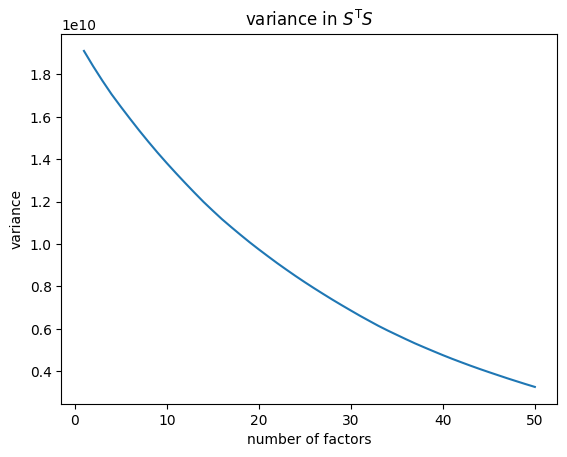

In [223]:
plt.plot(np.arange(1, numFactor + 1), varS1Ary)
plt.xlabel('number of factors')
plt.ylabel('variance')
plt.title('variance in $S^\mathrm{T}S$')
plt.show()

This plot looks good, as we do expect the variance in the cross-product matrix is gradually depleted. However, when we plot `varX` and `varY` (variances explained in the matrices), this does not look correct as they are decreasing as number of factor increases.

Hence, I conjecture that `varX` and `varY` really are variance yet to be explained. Now, we replot the graph, it should be

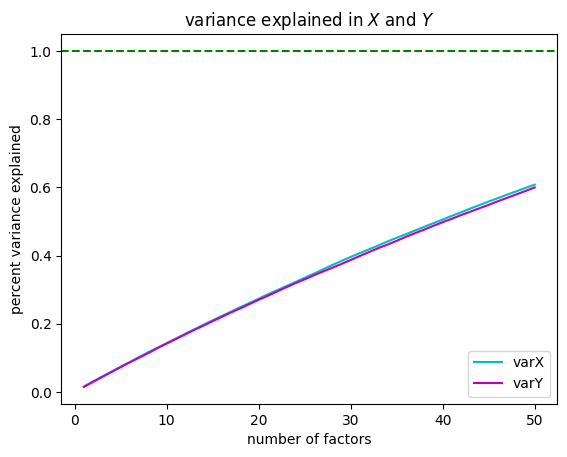

In [226]:
plotVar(varX1Ary, varY1Ary, varX1Total, varY1Total)

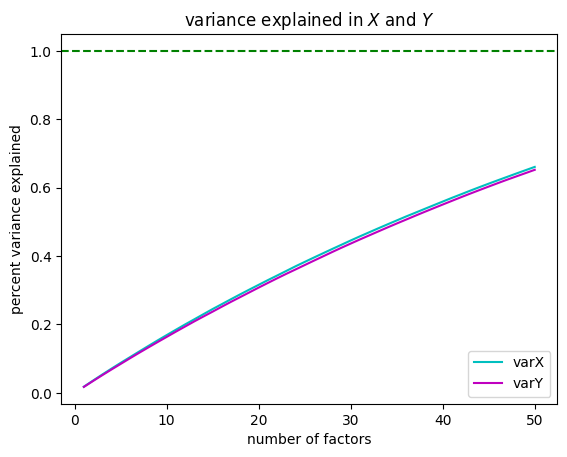

In [227]:
plotVar(varX2Ary, varY2Ary, varX2Total, varY2Total)

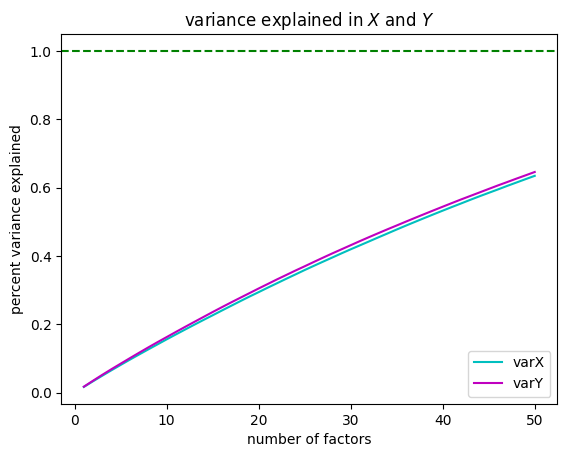

In [260]:
plotVar(varX3Ary, varY3Ary, varX3Total, varY3Total)

Aside: It took me about 2min to find a dominant eigenvector of a matrix of size $10000\times 10000$, but I'm not able to run $100000\times 100000$ on my local computer. We might need to use the cluster or a sparse approach.

In [24]:
temp = np.random.randn(100000,10000)
time1 = time.time()
sp.eigh(np.dot(temp.T,temp), subset_by_index=[10000-1, 10000-1])
time2 = time.time()
time2-time1

132.28715991973877

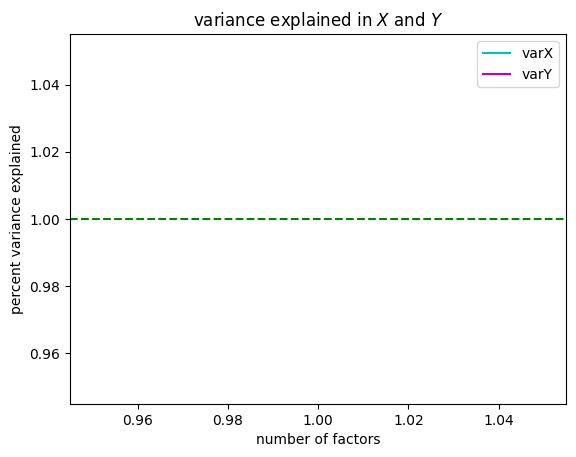

In [264]:
test1X = np.identity(2)
test1Y = np.identity(2)
B1, _, varTest1XAry, varTest1YAry, varTest1SAry = SIMPLS(test1X, test1Y, 2)
plotVar(varTest1XAry, varTest1YAry, getVariance(test1X), getVariance(test1Y))

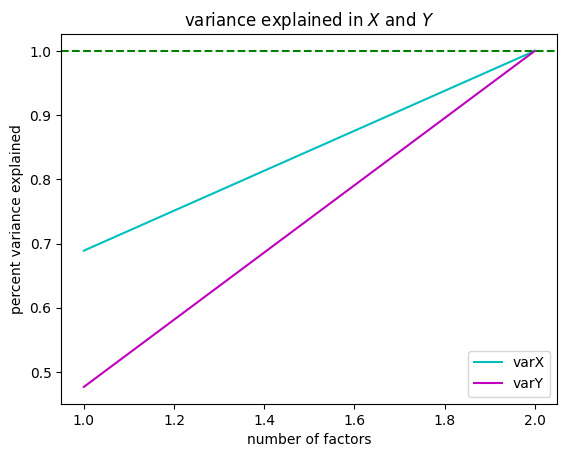

In [266]:
test2X = np.array([[1,2,0],[2,0,1],[1,1,2]])
test2Y = test2X @ test2X
B2, _, varTest2XAry, varTest2YAry, varTest2SAry = SIMPLS(test2X, test2Y, 3)
plotVar(varTest2XAry, varTest2YAry, getVariance(test2X), getVariance(test2Y))

In [277]:
np.tile(np.mean(test2Y, axis = 0),(3,1)) + (test2X - np.tile(np.mean(test2X, axis = 0),(3,1))) @ B2

array([[4.11187998, 3.72469885, 2.58877824],
       [3.40265561, 3.91055218, 1.27180339],
       [5.48546441, 3.36474897, 5.13941837]])

In [279]:
getMean(test2X)

array([[1.33333333, 1.        , 1.        ],
       [1.33333333, 1.        , 1.        ],
       [1.33333333, 1.        , 1.        ]])

The following example is given by the SIMPLS paper on page 260. The results pretty much match the values presented by the paper. I spotted a typo in the algorithm on page 262 where it's supposed to be
$$
r = \dfrac{r}{||r||_2}
$$
rather than
$$
r = \dfrac{r}{||t||_2}
$$
This is supported by statement on page 252.

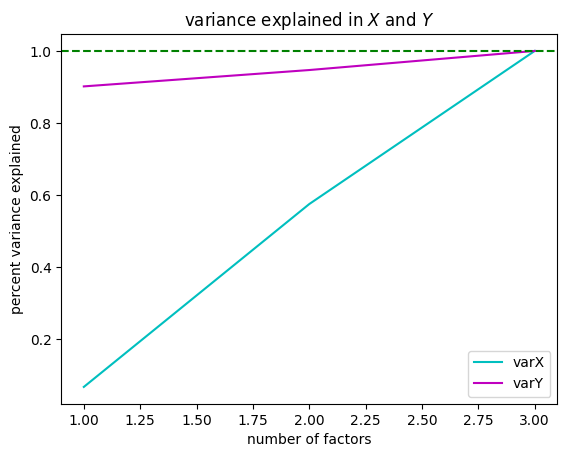

In [281]:
test3X = np.array([[-4,2,1], [-4,-2,-1],[4,2,-1],[4,-2,1]])
test3Y = np.array([[430, -94], [-436, 12], [-361, -22], [367, 104]])
B3, _, varTest3XAry, varTest3YAry, varTest3SAry = SIMPLS(test3X, test3Y, 3)
plotVar(varTest3XAry, varTest3YAry, getVariance(test3X), getVariance(test3Y))

In [236]:
varTest3XAry/getVariance(test3X)*100

array([ 6.71711669, 50.77280992, 42.51007339])

In [206]:
varTest3YAry/getVariance(test3Y)*100

array([90.15238839,  4.5418929 ,  5.30571871])

In [282]:
getMean(test3Y) + (test3X - getMean(test3X)) @ B3

array([[ 100.01935635,   15.87484227],
       [ 401.65078987,   63.74908989],
       [-628.04729744,  -99.68222303],
       [ 126.37715123,   20.05829087]])

In [284]:
test3Y

array([[ 430,  -94],
       [-436,   12],
       [-361,  -22],
       [ 367,  104]])

In [285]:
B3

array([[ -62.70876828,   -9.95299152],
       [-132.00698527,  -20.95184519],
       [ 113.19825379,   17.96656657]])